In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
from sqlalchemy import inspect


In [6]:
# find the table names 
insp= inspect(engine)
print(insp.get_table_names())

['measurement', 'station']


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
#AutomapBase.prepare.autoload_with

C:\Users\raghe\AppData\Local\Temp\ipykernel_34224\1464019735.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# measurement- get the variable types of the table columns

columns = insp.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [13]:
# station- get the variable types of the table columns
columns = insp.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


In [16]:
# find the most recent and last dates in the data set
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earliest[0]} , Latest: {latest[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


#variable start_dateis an object and the "most_recent_date" is 08-23-2017 
# Calculate the date one year from the last date in data set.
latestdate = dt.datetime.strptime(latest[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precip = precip.dropna(how='any') # clean up non value entries

# Sort the dataframe by date
precip = precip.sort_values(["Date"], ascending=True)
precip = precip.set_index("Date")

#display data frame
precip.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


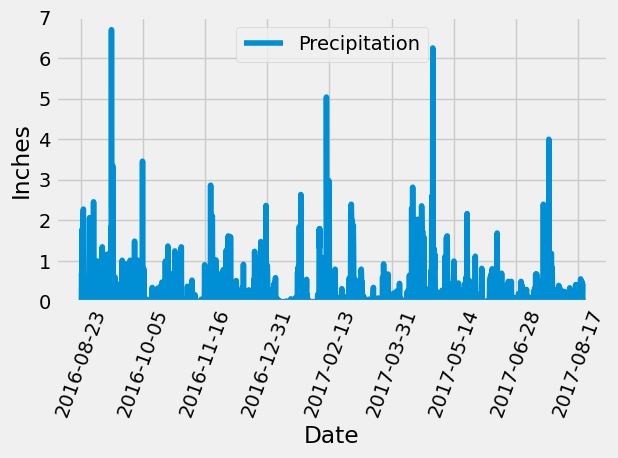

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data

precip.plot()
plt.ylim(0,7)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations= session.query(Station.id).count()
total_stations

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station).all() 

print(most_active_stations) 

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station_data

(54.0, 85.0, 71.66378066378067)

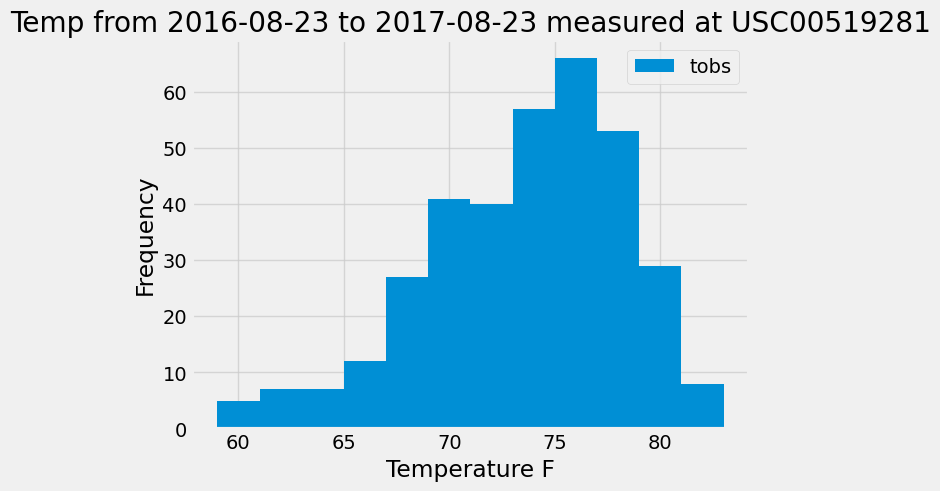

In [27]:
# Using the most active station id STATION ID= USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find most recent date for Station: USC00519281 in the Measurement table
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_stations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])


#plot histogram
# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature F')
plt.title(f"Temp from {querydate} to {latest[0]} measured at USC00519281")
plt.legend()


# Close Session

In [28]:
# Close Session
session.close()